# Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint

In [34]:
# Generate normal data with gradual increases
def generate_normal_data(size, start=10):
    data = [start]
    counter = 0

    for _ in range(size - 1):
        counter += 1
        if counter <= 10:  # Gradual increase
            next_val = data[-1] + np.random.uniform(0.1, 0.5)
        elif 10 < counter <= 20:  # Gradual decrease
            next_val = data[-1] - np.random.uniform(0.1, 0.5)
        else:
            counter = 0
            continue
        # Ensure the value stays within the range [10, 30]
        next_val = max(10, min(30, next_val))
        data.append(next_val)

    return np.array(data)

# Generate anomalies (sudden spikes)
def add_anomalies(data, num_anomalies=100):
    data_with_anomalies = data.copy()
    anomaly_indices = np.random.choice(len(data), num_anomalies, replace=False)
    for idx in anomaly_indices:
        data_with_anomalies[idx] += np.random.uniform(5, 15)  # Sudden spike
    return data_with_anomalies, anomaly_indices

In [35]:
# Generate dataset
np.random.seed(42)
normal_data = generate_normal_data(1000)
data_with_anomalies, anomalies = add_anomalies(normal_data)

In [36]:
# Save to CSV for future use
dataset = pd.DataFrame({"temperature": data_with_anomalies, "is_anomaly": 0})
dataset.loc[anomalies, "is_anomaly"] = 1
dataset.to_csv("temperature_data.csv", index=False)

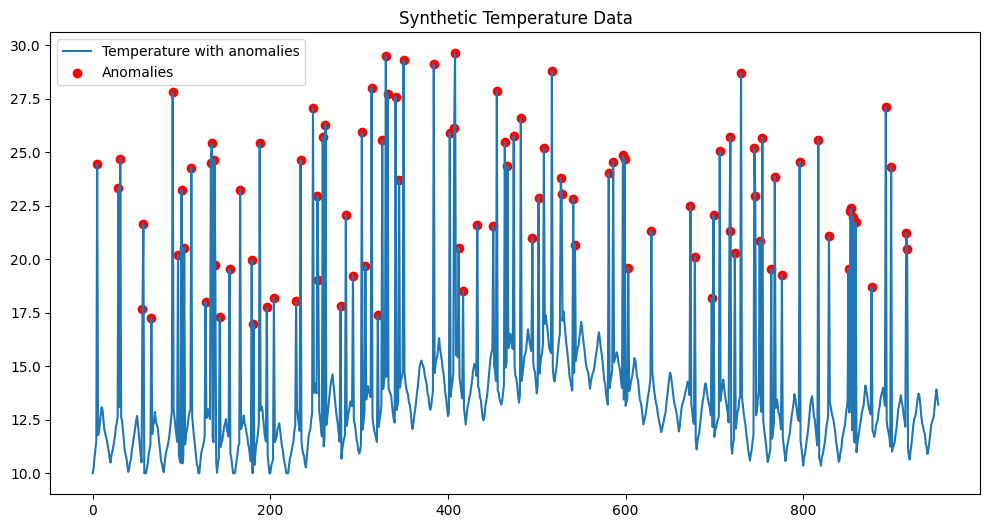

In [37]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(data_with_anomalies, label="Temperature with anomalies")
plt.scatter(anomalies, data_with_anomalies[anomalies], color="red", label="Anomalies")
plt.title("Synthetic Temperature Data")
plt.legend()
plt.show()

# Model Training

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

In [39]:
# Load dataset
data = pd.read_csv("temperature_data.csv")
temperature = data["temperature"].values

In [40]:
# Normalize data
scaler = MinMaxScaler()
temperature = scaler.fit_transform(temperature.reshape(-1, 1))

In [41]:
# Create sequences
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

SEQ_LENGTH = 10
X, y = create_sequences(temperature, SEQ_LENGTH)

In [42]:
# Split into training and testing
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [76]:
# Build LSTM model
model = Sequential([
    Dense(8, activation="relu", input_shape=(X_train.shape[1],)),  # Encoder
    Dense(4, activation="relu"),  # Bottleneck (compressed representation)
    Dense(8, activation="relu"),  # Decoder
    Dense(X_train.shape[1])  # Output layer to reconstruct the input
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [77]:
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 8)                   │              88 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 8)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 254 (1016.00 B)

 Trainable params: 254 (1016.00 B)

 Non-trainable params: 0 (0.00 B)

In [78]:
# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0808 - val_loss: 0.0530
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0660 - val_loss: 0.0406
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0640 - val_loss: 0.0314
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0439 - val_loss: 0.0292
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0427 - val_loss: 0.0275
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0343 - val_loss: 0.0270
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0333 - val_loss: 0.0271
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0364 - val_loss: 0.0269
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0316 - val_loss: 0.0268
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0379 - val_loss: 0.0272
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0359 - val_loss: 0.0267
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0326 - val_l

In [79]:
# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0307 
Test Loss: 0.029675303027033806


# Export Model for Pico W

In [80]:
# Save model as TensorFlow Lite
model.export("temp_anomaly_model")
model.save("temp_anomaly_model.keras")

Saved artifact at 'temp_anomaly_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='keras_tensor_52')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137530761329680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137530761222224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137530761498288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137530761495472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137530761500576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137530761499168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137530761498112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137530761500400: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [81]:
# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model("temp_anomaly_model")
# Enable resource variables
converter.experimental_enable_resource_variables = True
# Disable experimental lowering of tensor list ops
converter._experimental_lower_tensor_list_ops = False
# Use Select TF ops
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

In [82]:
# Save TensorFlow Lite model
with open("temp_anomaly_model.tflite", "wb") as f:
    f.write(tflite_model)

# Model Evaluation

In [83]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load test dataset
data = pd.read_csv("temperature_data.csv")
temperature = data["temperature"].values
true_anomalies = data["is_anomaly"].values

# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
temperature = scaler.fit_transform(temperature.reshape(-1, 1))

# Create sequences for testing
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

SEQ_LENGTH = 10
X_test, y_test = create_sequences(temperature, SEQ_LENGTH)

# Load the trained model
model = tf.keras.models.load_model("temp_anomaly_model.keras")

In [93]:
# Predict the next value for the test data
y_pred = model.predict(X_test)

# Reshape predictions back to the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# 6. Define anomaly detection based on reconstruction error (threshold)
reconstruction_error = np.mean(np.abs(y_test_rescaled - y_pred_rescaled), axis=1)

threshold = np.percentile(reconstruction_error, 90)  # Flagging top 5% as anomalies
print("Dynamic threshold:", threshold)

# Flag anomalies
anomalies_detected = reconstruction_error > threshold

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Dynamic threshold: 4.656454042123215


In [94]:
# Create labels for detected anomalies
predicted_anomalies = np.zeros(len(true_anomalies))
predicted_anomalies[SEQ_LENGTH:] = anomalies_detected.astype(int)

# Compute classification metrics
cm = confusion_matrix(true_anomalies[SEQ_LENGTH:], predicted_anomalies[SEQ_LENGTH:])
report = classification_report(true_anomalies[SEQ_LENGTH:], predicted_anomalies[SEQ_LENGTH:], target_names=["Normal", "Anomaly"])
precision = precision_score(true_anomalies[SEQ_LENGTH:], predicted_anomalies[SEQ_LENGTH:])
recall = recall_score(true_anomalies[SEQ_LENGTH:], predicted_anomalies[SEQ_LENGTH:])
f1 = f1_score(true_anomalies[SEQ_LENGTH:], predicted_anomalies[SEQ_LENGTH:])

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")


Confusion Matrix:
 [[839   5]
 [  9  90]]

Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       844
     Anomaly       0.95      0.91      0.93        99

    accuracy                           0.99       943
   macro avg       0.97      0.95      0.96       943
weighted avg       0.98      0.99      0.99       943

Precision: 0.95, Recall: 0.91, F1-Score: 0.93


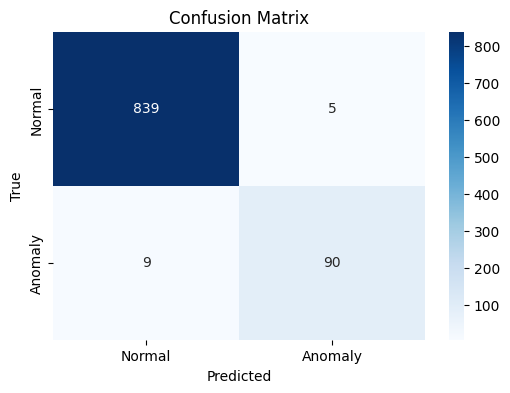

In [95]:
# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

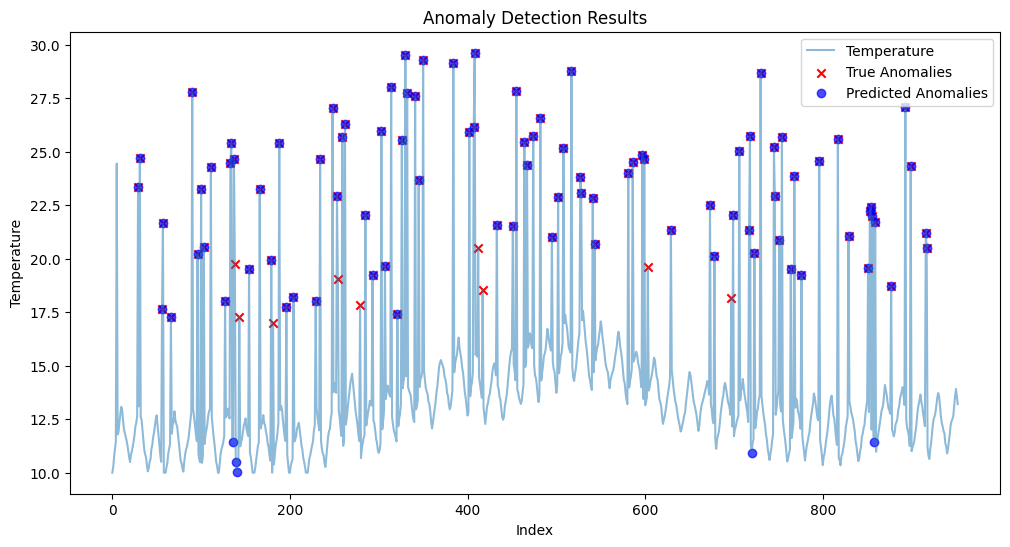

In [96]:
# Plot true vs predicted anomalies
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["temperature"], label="Temperature", alpha=0.5)
plt.scatter(data.index[SEQ_LENGTH:][true_anomalies[SEQ_LENGTH:] == 1],
            data["temperature"][SEQ_LENGTH:][true_anomalies[SEQ_LENGTH:] == 1],
            color="red", label="True Anomalies", marker="x")
plt.scatter(data.index[SEQ_LENGTH:][predicted_anomalies[SEQ_LENGTH:] == 1],
            data["temperature"][SEQ_LENGTH:][predicted_anomalies[SEQ_LENGTH:] == 1],
            color="blue", label="Predicted Anomalies", marker="o", alpha=0.7)
plt.legend()
plt.title("Anomaly Detection Results")
plt.xlabel("Index")
plt.ylabel("Temperature")
plt.show()